<a href="https://colab.research.google.com/github/krell11/customer_churn_prediction/blob/master/ML_Cource.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
print("Contents of '/content/drive/MyDrive/Colab Notebooks/':")
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/'))

Mounted at /content/drive
Contents of '/content/drive/MyDrive/Colab Notebooks/':
['datasets', 'Untitled0.ipynb', 'ML_Cource.ipynb']


In [2]:
PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/"

In [3]:
import numpy as np
import pandas as pd

In [34]:
clients = pd.read_csv(PATH + 'clients.csv')
report_dates = pd.read_csv(PATH + 'report_dates.csv', parse_dates=['report_dt'])
train_labels = pd.read_csv(PATH + 'train.csv')
transactions = pd.read_csv(PATH + 'transactions.csv', parse_dates=['transaction_dttm'])



In [35]:
clients = clients.merge(report_dates, on='report', how='left')

In [36]:
clients

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_dt
0,3,2,ОТ 101 ДО 500,0,3,2022-08-31 03:00:00
1,9,1,БОЛЕЕ 1001,0,3,2022-07-31 03:00:00
2,13,6,ОТ 501 ДО 1000,0,2,2022-12-31 03:00:00
3,37,5,БОЛЕЕ 1001,0,2,2022-11-30 03:00:00
4,41,1,ОТ 101 ДО 500,0,2,2022-07-31 03:00:00
...,...,...,...,...,...,...
95995,562043,12,NaN,0,2,2023-06-30 03:00:00
95996,562205,12,NaN,0,1,2023-06-30 03:00:00
95997,562312,12,NaN,0,0,2023-06-30 03:00:00
95998,562721,12,NaN,0,2,2023-06-30 03:00:00


In [37]:
tx = transactions.merge(clients[['user_id', 'report_dt']], on='user_id', how='inner')

In [38]:
tx['days_before'] = (tx['report_dt'] - tx['transaction_dttm']).dt.days

In [39]:
tx

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,report_dt,days_before
0,3,3,1,-183.883957,2022-01-28 12:05:33,2022-08-31 03:00:00,214
1,3,3,1,-3206.437012,2022-01-28 12:52:30,2022-08-31 03:00:00,214
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2022-08-31 03:00:00,195
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2022-08-31 03:00:00,174
4,3,0,1,5297.908691,2022-03-12 18:11:31,2022-08-31 03:00:00,171
...,...,...,...,...,...,...,...
13075018,562740,155,1,-2484.366211,2023-03-20 11:52:09,2023-06-30 03:00:00,101
13075019,562740,9,1,-187.658463,2023-03-20 12:10:22,2023-06-30 03:00:00,101
13075020,562740,1,1,-891.933350,2023-03-20 15:53:37,2023-06-30 03:00:00,101
13075021,562740,13,1,-464.467316,2023-03-20 15:54:49,2023-06-30 03:00:00,101


In [40]:
aggs = tx.groupby('user_id').agg({
    'days_before': ['min'],
    'transaction_amt': ['count', 'sum', 'mean', 'std'],
    'mcc_code': ['nunique'],
    'currency_rk': ['nunique']
})

aggs.columns = [
    'recency',
    'total_cnt',
    'total_sum',
    'avg_check',      # Средний чек за все время
    'std_check',      # СКО
    'unique_mcc',
    'unique_currency'
]

aggs['std_check'] = aggs['std_check'].fillna(0)

features = aggs.reset_index()
features.describe()

,user_id,recency,total_cnt,total_sum,avg_check,std_check,unique_mcc,unique_currency
count,96000.000000,96000.000000,96000.000000,9.600000e+04,96000.000000,96000.000000,96000.000000,96000.000000
mean,276382.605083,107.678438,136.198156,-1.399246e+05,-1543.424054,8402.487533,15.584750,1.118073
std,159494.175948,11.094424,148.584868,3.687130e+05,7425.218183,11750.191740,10.802958,0.325844
min,3.000000,101.000000,11.000000,-1.795695e+07,-132627.702257,0.839097,1.000000,1.000000
25%,136955.000000,101.000000,35.000000,-2.168482e+05,-1843.031308,1715.490561,7.000000,1.000000
50%,277938.000000,103.000000,82.000000,-8.570759e+04,-712.625322,4266.202807,13.000000,1.000000
75%,414695.250000,109.000000,186.000000,-6.480743e+03,-123.586260,10130.151015,22.000000,1.000000
max,562740.000000,191.000000,1497.000000,1.134800e+07,213834.371538,177228.484424,95.000000,4.000000


In [41]:
aggs

,recency,total_cnt,total_sum,avg_check,std_check,unique_mcc,unique_currency
user_id,,,,,,,
3,108,11,13706.416641,1246.037876,60860.880477,4,1
9,102,90,-323434.666813,-3593.718520,11797.055119,22,1
13,114,22,-124717.379150,-5668.971780,23507.953991,4,2
37,104,315,-331859.599463,-1053.522538,3913.114835,28,1
41,103,16,-108586.614166,-6786.663385,5251.737982,5,1
...,...,...,...,...,...,...,...
562043,142,37,-29581.256115,-799.493409,2136.038913,12,1
562205,102,151,-40491.908630,-268.158335,590.682233,15,1
562312,122,56,-18537.821270,-331.032523,309.587795,7,1


In [42]:
df_full = clients.merge(features, on='user_id', how='left')

In [43]:
df_full

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_dt,recency,total_cnt,total_sum,avg_check,std_check,unique_mcc,unique_currency
0,3,2,ОТ 101 ДО 500,0,3,2022-08-31 03:00:00,108,11,13706.416641,1246.037876,60860.880477,4,1
1,9,1,БОЛЕЕ 1001,0,3,2022-07-31 03:00:00,102,90,-323434.666813,-3593.718520,11797.055119,22,1
2,13,6,ОТ 501 ДО 1000,0,2,2022-12-31 03:00:00,114,22,-124717.379150,-5668.971780,23507.953991,4,2
3,37,5,БОЛЕЕ 1001,0,2,2022-11-30 03:00:00,104,315,-331859.599463,-1053.522538,3913.114835,28,1
4,41,1,ОТ 101 ДО 500,0,2,2022-07-31 03:00:00,103,16,-108586.614166,-6786.663385,5251.737982,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,12,NaN,0,2,2023-06-30 03:00:00,142,37,-29581.256115,-799.493409,2136.038913,12,1
95996,562205,12,NaN,0,1,2023-06-30 03:00:00,102,151,-40491.908630,-268.158335,590.682233,15,1
95997,562312,12,NaN,0,0,2023-06-30 03:00:00,122,56,-18537.821270,-331.032523,309.587795,7,1
95998,562721,12,NaN,0,2,2023-06-30 03:00:00,105,85,-164004.761685,-1929.467785,4172.623511,11,1


In [18]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=833d8230ba50dc7b711d05394f56f58c1bc27654308c4e09f2a18d42b5e2c0ff
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [44]:
num_features = [
    'recency',
    'total_cnt',
    'total_sum',
    'avg_check',
    'std_check',
    'unique_mcc',
    'unique_currency'
]
df_full[num_features] = df_full[num_features].fillna(0)

money_cols = ['total_sum', 'avg_check', 'std_check']

In [45]:
for col in money_cols:
  df_full[col] = np.log1p(df_full[col].abs())

In [46]:
cat_cols = ['employee_count_nm', 'bankemplstatus']
for col in cat_cols:
    df_full[col] = df_full[col].fillna('MISSING').astype(str)

In [47]:
labeled_df = df_full.merge(train_labels, on='user_id', how='inner')

In [48]:
labeled_df

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_dt,recency,total_cnt,total_sum,avg_check,std_check,unique_mcc,unique_currency,target,time
0,3,2,ОТ 101 ДО 500,0,3,2022-08-31 03:00:00,108,11,9.525692,7.128526,11.016362,4,1,0,77
1,13,6,ОТ 501 ДО 1000,0,2,2022-12-31 03:00:00,114,22,11.733814,8.642939,10.065137,4,2,0,86
2,37,5,БОЛЕЕ 1001,0,2,2022-11-30 03:00:00,104,315,12.712470,6.960843,8.272344,28,1,0,89
3,41,1,ОТ 101 ДО 500,0,2,2022-07-31 03:00:00,103,16,11.595313,8.822862,8.566505,5,1,0,57
4,42,12,ДО 10,0,3,2023-06-30 03:00:00,102,59,9.344048,5.271572,8.815234,20,1,0,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,561824,12,MISSING,0,0,2023-06-30 03:00:00,102,148,11.221640,6.226393,6.954560,28,1,0,91
63996,562043,12,MISSING,0,2,2023-06-30 03:00:00,142,37,10.294930,6.685228,7.667176,12,1,0,75
63997,562312,12,MISSING,0,0,2023-06-30 03:00:00,122,56,9.827622,5.805233,5.738467,7,1,0,91
63998,562721,12,MISSING,0,2,2023-06-30 03:00:00,105,85,12.007657,7.565518,8.336540,11,1,0,29


Exploratory Data Analysis

In [49]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [50]:
kmf = KaplanMeierFitter()
kmf.fit(durations=labeled_df['time'], event_observed=labeled_df['target'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 64000 total observations, 58583 right-censored observations>

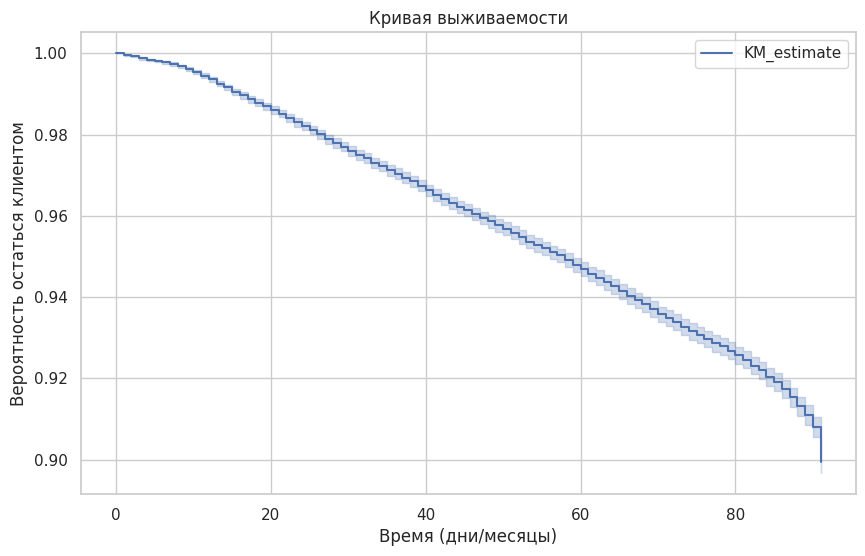

In [51]:
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title("Кривая выживаемости")
plt.xlabel("Время (дни/месяцы)")
plt.ylabel("Вероятность остаться клиентом")
plt.grid(True)
plt.show()

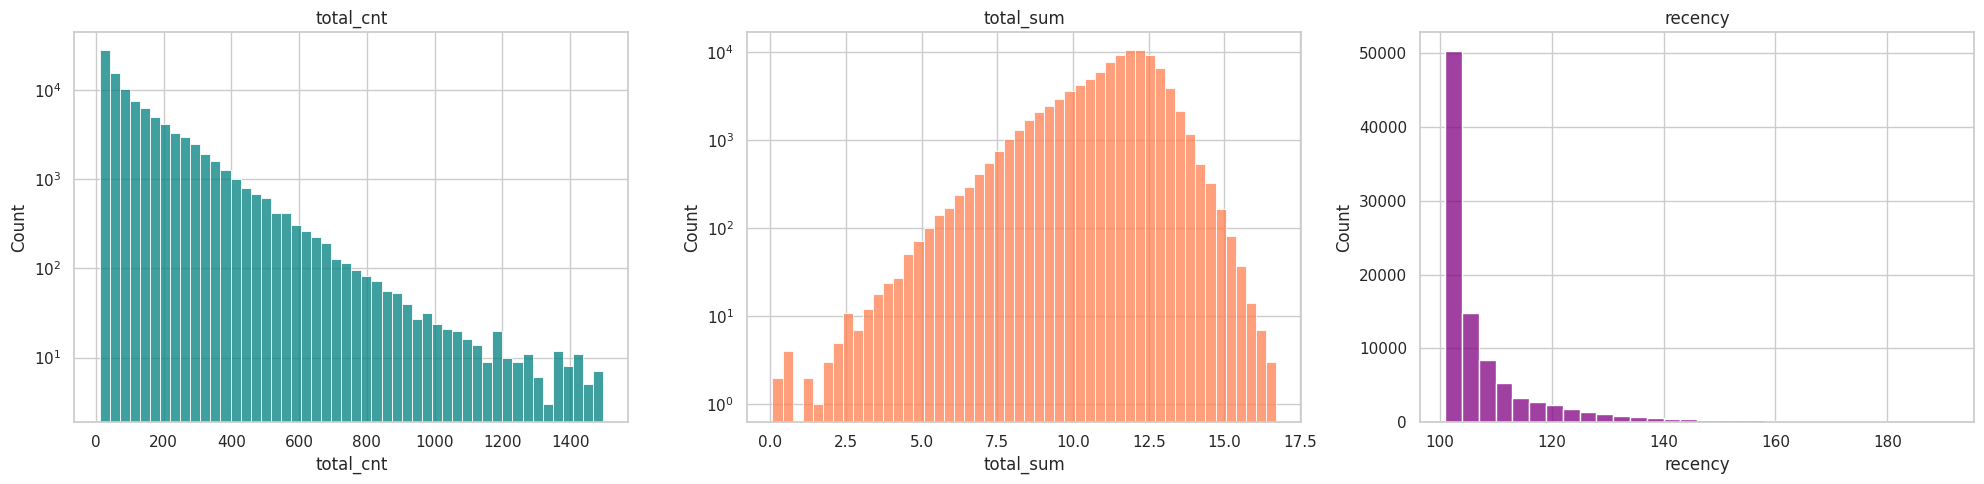

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(df_full['total_cnt'], bins=50, ax=axes[0], color='teal')
axes[0].set_title('total_cnt')
axes[0].set_yscale('log')

sns.histplot(df_full['total_sum'], bins=50, ax=axes[1], color='coral')
axes[1].set_title('total_sum')
axes[1].set_yscale('log')

sns.histplot(df_full['recency'], bins=30, ax=axes[2], color='purple')
axes[2].set_title('recency')

plt.tight_layout()
plt.show()

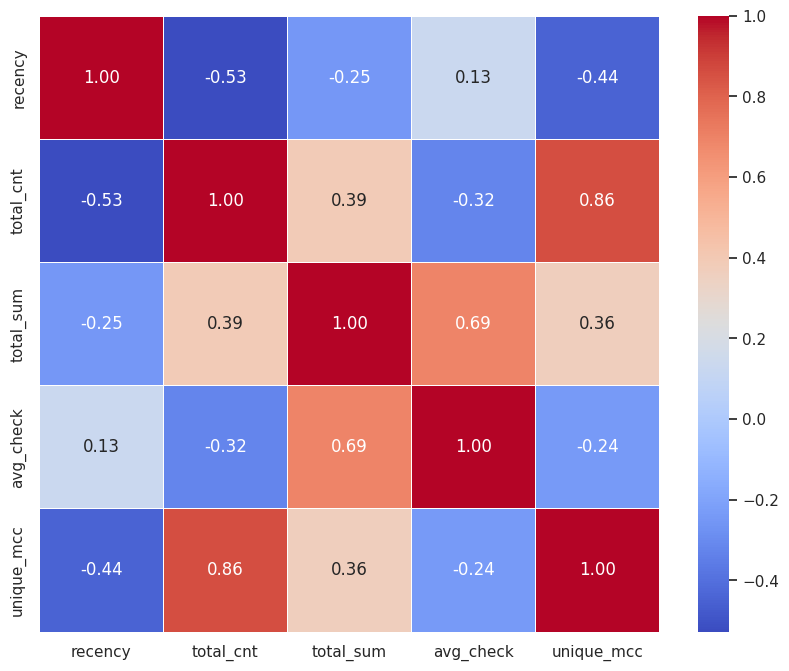

In [84]:
check_cols = ['recency', 'total_cnt', 'total_sum', 'avg_check', 'unique_mcc']

plt.figure(figsize=(10, 8))

corr = df_full[check_cols].corr(method='spearman')

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

/tmp/ipython-input-1221059471.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=train_labels, palette='viridis')


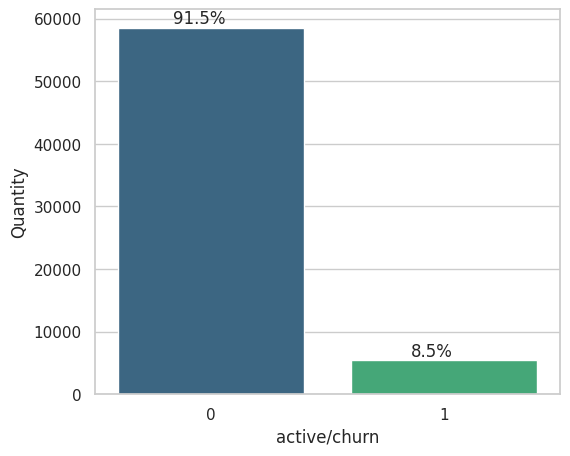

In [56]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='target', data=train_labels, palette='viridis')

total = len(train_labels)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.xlabel('active/churn')
plt.ylabel('Quantity')
plt.show()

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
train_df, val_df = train_test_split(
    labeled_df,
    test_size=0.1,
    random_state=42,
    stratify=labeled_df['target']
)

In [60]:
drop_cols = ['user_id', 'report', 'report_dt', 'target', 'time']
X_train = train_df.drop(columns=drop_cols, errors='ignore')
X_val = val_df.drop(columns=drop_cols, errors='ignore')

In [61]:
y_train = train_df['time'] * (2 * train_df['target'] - 1)
y_val = val_df['time'] * (2 * val_df['target'] - 1)

In [62]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.1 MB/s eta 0:00:00


In [63]:
from catboost import CatBoostRegressor, Pool

In [64]:
train_pool = Pool(X_train, label=y_train, cat_features=cat_cols)
val_pool = Pool(X_val, label=y_val, cat_features=cat_cols)

In [65]:
model = CatBoostRegressor(
    loss_function='Cox',
    eval_metric='Cox',
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    verbose=100,
    early_stopping_rounds=50
)

In [66]:
model.fit(train_pool, eval_set=val_pool)

0:	learn: -52059.4052159	test: -4580.8370939	best: -4580.8370939 (0)	total: 117ms	remaining: 1m 57s
100:	learn: -49936.8593171	test: -4345.7011731	best: -4345.7011731 (100)	total: 6.96s	remaining: 1m 1s
200:	learn: -49784.0504158	test: -4341.4086310	best: -4341.4086310 (200)	total: 14.3s	remaining: 56.8s
300:	learn: -49678.4787557	test: -4341.0869156	best: -4341.0869156 (300)	total: 20.9s	remaining: 48.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = -4340.14478
bestIteration = 337

Shrink model to first 338 iterations.


In [67]:
preds_risk = model.predict(X_val)

In [68]:
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.7 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.5
    Uninstalling osqp-1.0.5:
      Successfully uninstalled osqp-1.0.5


In [69]:
from sksurv.metrics import concordance_index_censored

In [70]:
max(preds_risk)

np.float64(3.328521539107137)

In [71]:
events = val_df['target'].astype(bool)
times = val_df['time']
c_index = concordance_index_censored(events, times, preds_risk)[0]

In [72]:
c_index

np.float64(0.7476571803442139)

In [74]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

Оптимальный порог риска: 1.0600
Максимальный F1-score: 0.3377


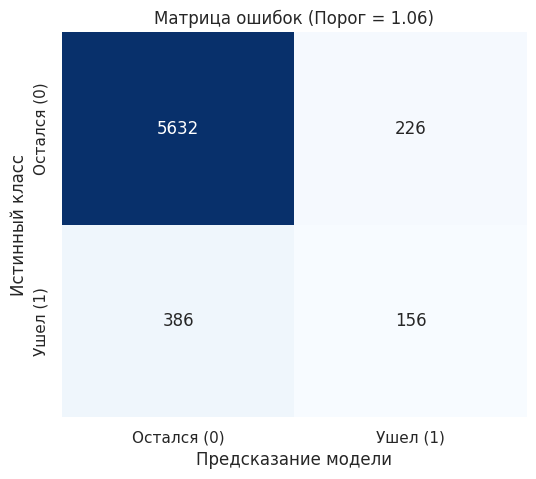

In [75]:
risk_pred = model.predict(X_val)
y_true_binary = val_df['target'].values

thresholds = np.linspace(risk_pred.min(), risk_pred.max(), 100)
scores = [f1_score(y_true_binary, (risk_pred > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(scores)]

print(f"Оптимальный порог риска: {best_threshold:.4f}")
print(f"Максимальный F1-score: {max(scores):.4f}")

y_pred_binary = (risk_pred > best_threshold).astype(int)

cm = confusion_matrix(y_true_binary, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказание модели')
plt.ylabel('Истинный класс')
plt.title(f'Матрица ошибок (Порог = {best_threshold:.2f})')
plt.xticks([0.5, 1.5], ['Остался (0)', 'Ушел (1)'])
plt.yticks([0.5, 1.5], ['Остался (0)', 'Ушел (1)'])
plt.show()

In [76]:
from sklearn.model_selection import StratifiedKFold
from catboost import Pool

In [85]:
from sklearn.model_selection import StratifiedKFold
from catboost import Pool

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []
models = []
c_scores = []
X = labeled_df.drop(columns=drop_cols, errors='ignore')
y_stratify = labeled_df['target']
y_cox = labeled_df['time'] * (2 * labeled_df['target'] - 1)


In [87]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_stratify)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y_cox.iloc[train_idx], y_cox.iloc[val_idx]

    train_pool_fold = Pool(X_train_fold, label=y_train_fold, cat_features=cat_cols)
    val_pool_fold = Pool(X_val_fold, label=y_val_fold, cat_features=cat_cols)

    model_fold = CatBoostRegressor(
        loss_function='Cox',
        eval_metric='Cox',
        iterations=500,
        learning_rate=0.05,
        depth=6,
        verbose=False,
        early_stopping_rounds=30
    )

    model_fold.fit(train_pool_fold, eval_set=val_pool_fold)

    event_bool = y_val_fold > 0
    time_abs = y_val_fold.abs()
    risk_pred = model_fold.predict(X_val_fold)

    best_score = model_fold.get_best_score()['validation']['Cox']
    scores.append(best_score)
    c_index = concordance_index_censored(event_bool, time_abs, risk_pred)[0]
    c_scores.append(c_index)

    print(f"Fold {fold+1}: Cox Score = {best_score:.4f}")

print(f"\nСредний результат: {np.mean(scores):.4f} (std: {np.std(scores):.4f})")

Fold 1: Cox Score = -9511.4755
Fold 2: Cox Score = -9468.8288
Fold 3: Cox Score = -9435.5247
Fold 4: Cox Score = -9565.8229
Fold 5: Cox Score = -9490.5962

Средний результат: -9497.2873 (std: 40.3506)


In [88]:
c_scores

[np.float64(0.7372136643252143),
 np.float64(0.7526082693926508),
 np.float64(0.7489997563290546),
 np.float64(0.7291485429988083),
 np.float64(0.7434292111242397)]

In [89]:

X = labeled_df.drop(columns=drop_cols, errors='ignore')
y_cox = labeled_df['time'] * (2 * labeled_df['target'] - 1)
cat_cols = ['employee_count_nm', 'bankemplstatus']

full_pool = Pool(X, label=y_cox, cat_features=cat_cols)

grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [500, 700, 1000]
}

model_search = CatBoostRegressor(
    loss_function='Cox',
    eval_metric='Cox',
    verbose=False,
    early_stopping_rounds=50
)



In [91]:
from google.colab import output
output.enable_custom_widget_manager()

In [92]:
randomized_search_result = model_search.randomized_search(
    grid,
    X=full_pool,
    cv=3,                 # Внутренняя кросс-валидация на 3 фолда
    n_iter=20,            # Сколько случайных комбинаций проверить
    partition_random_seed=42,
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    plot=True,
    verbose=False
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = -9779.234103
bestIteration = 499


bestTest = -9760.716986
bestIteration = 494


bestTest = -9766.15614
bestIteration = 495

Stopped by overfitting detector  (50 iterations wait)

bestTest = -9759.437011
bestIteration = 475


bestTest = -9772.993113
bestIteration = 699

Stopped by overfitting detector  (50 iterations wait)

bestTest = -9763.984106
bestIteration = 519

Stopped by overfitting detector  (50 iterations wait)

bestTest = -9759.437011
bestIteration = 475


bestTest = -9767.151864
bestIteration = 997

Stopped by overfitting detector  (50 iterations wait)

bestTest = -9756.20642
bestIteration = 141


bestTest = -9777.312706
bestIteration = 499

Stopped by overfitting detector  (50 iterations wait)

bestTest = -9756.20642
bestIteration = 141

Stopped by overfitting detector  (50 iterations wait)

bestTest = -9757.017875
bestIteration = 271

Stopped by overfitting detector  (50 iterations wait)

bestTest = -9755.756538
bestIteration = 352

Stopped by overfitting dete

In [93]:
randomized_search_result

{'params': {'depth': 7,
  'learning_rate': 0.03,
  'l2_leaf_reg': 1,
  'iterations': 700},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45